# Q-Learning in Python

Ein Programm für Q-Learning sollte die 3 folgenden grundlegenden Klassen enthalten:

1. Eine [Umgebung](#1---die-umgebung)
2. Eine [Q-Tabelle](#2---die-q-tabelle)
3. Einen [Agenten](#3---der-agent)

> Zum <b>Überspringen</b> der Implementierung um direkt zum Testen zu gelangen, klicke [hier](#4---testen).

Wir betrachten das Frozen-Lake Beispiel:
- Wir befinden uns auf einem zugefrorenen See, der in Kacheln eingeteilt ist.
- Wir können uns von einer Kachel in eine benachbarte Kachel bewegen.
- Unser Ziel ist es uns von einer bestimmten *Start-Kachel* in eine *Ziel-Kachel* zu begeben.
- Jede Kachel hat eine der folgenden Eigenschaften:
    - *Start* oder *Ziel* Kachel 
    - *Normale* Oberfläche
    - *Loch*, in das man hineinfallen kann 
- Für das Erreichen des Ziels gibt es eine Belohnung.

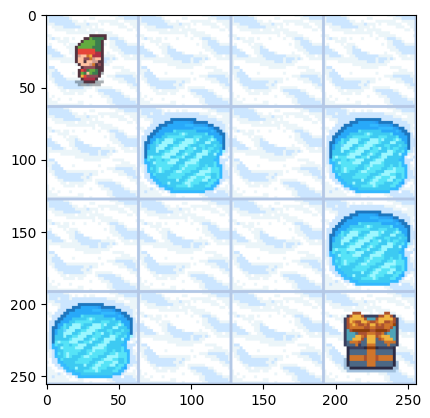

Wenn man auf einer Kachel steht, kann man sich in 4 (Himmels-)Richtungen bewegen:

In [1]:
from enum import Enum

class Richtung(Enum):
    NORD = 0
    OST = 1
    SUED = 2
    WEST = 3

    def getKachel(self, kachel:int):
        """ Gibt für eine übergebene Kachel, die Nachbar-Kachel in Richtung an.
        """
        vector = 0
        match self:
            case Richtung.NORD:
                vector = -4
            case Richtung.WEST:
                vector = -1
            case Richtung.SUED:
                vector = 4
            case Richtung.OST:
                vector = 1
        return kachel + vector
    
    def entgegengesetzte_Richtung(self):
        return Richtung((self.value + 2) %4)

In [2]:
# Die IMPORTS
# Falls es hier eine Fehlermeldung gibt, folgende Zeilen auskommentieren:
#! pip install --user matplotlib
#! pip install --user ipywidgets
#! pip install --user IPython
#! pip install --user PIL
#! pip install --user base64
#! pip install --user random
#! pip install --user io
#! pip install --user time

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.image as mpimg
from IPython.display import HTML, display, clear_output, Latex
import ipywidgets as widgets
from PIL import Image
import base64
import random
import io
import time

## 1 - Die Umgebung 

Q-Learning erfolgt über das Ausprobieren an Aktionen. Wir definieren für jede Kachel einen Reward:
- Fallen wir in ein Loch: **-25**
- Erreichen wir das Ziel: **+25**
- Damit unser Agent möglichst schnell in das Ziel kommt: **-1** für jeden Schritt

Wir geben jedem Zustand, also jeder Kachel eine eigene Nummer, um sie auseinander zu halten. 
(Erinnerung: Jedes Zustands-Aktions-Paar hat *theoretisch* seinen eigenen Wert.)
In unserem Beispiel ordnen wir der Reihe nach jeder Kachel eine Ganzzahl zu:

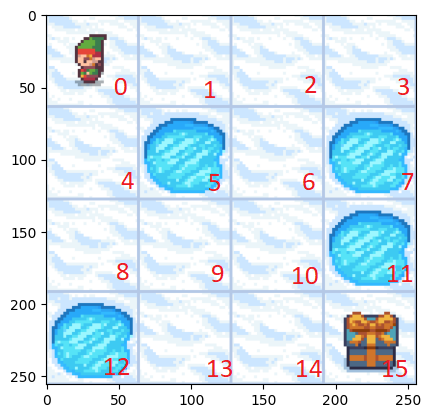

In [3]:
class Umgebung():
    def __init__(self):
        self.position_Figur:int
        """ Position der Figur
        """
        image_url = 'pics/Umgebung_numbered_blank.PNG'
        self.image = mpimg.imread(image_url)
        self.logbuch:list
        self.imZiel:bool
        self.reset()
        

    def reset(self):
        self.position_Figur = 0
        self.logbuch = []
        self.imZiel = False

    def valide_Richtungen(self, position = None) -> list:
        """ Gibt eine Liste mit allen begehbaren Richtungen zurück.
        """
        position = self.position_Figur if position is None else position
        richtungen = []
        if not position < 4:
            richtungen.append(Richtung.NORD)
        if not position > 11:
            richtungen.append(Richtung.SUED)
        if not position % 4 == 0:
            richtungen.append(Richtung.WEST)
        if not position % 4 == 3:
            richtungen.append(Richtung.OST)
        return richtungen 

    def step(self, richtung:Richtung) -> int:
        """Gibt für eine übergebene Richtung eine neue self.position_Figur zurück.
        """
        neue_Position = richtung.getKachel(self.position_Figur)
        self.position_Figur = neue_Position
        self.logbuch.append(richtung)
        return neue_Position
    
    def get_Belohnung(self, position = None) -> int:
        """Gibt die Belohnung für eine Position zurück. (Default: Position der Figur) -> Belohnungsfunktion.
        """
        position = position if position else self.position_Figur
        match position:
            case 15:
                self.imZiel = True
                return 25
            case 5| 7| 11| 12:
                return -25
            case _:
                return -1

    def fertig(self) -> bool:
        """True wenn fertig (im Ziel).
        """
        if self.position_Figur == 15:
            self.imZiel = True
        return self.imZiel
    
#_________________________________FÜR DIE VISUALISISERUNGEN__________________________________#

    def get_Picture_Location(self, kachel:int):
        """Gibt für eine Kachel-Nummer die Koordinaten der Mitte der Kachel im genutzten Bild zurück.
        """
        init = (92,62)
        return 92 + 92 * ( kachel % 4), 62 + 92*(int(kachel / 4))

    def visualisiere_Fortschritt(self)-> HTML:
        

        # Display the image with arrows
        fig, ax = plt.subplots()
        ax.imshow(self.image)
        
        # Um die Pfeile auf dem Bild zu generieren
        start_kachel = 0
        start_point = self.get_Picture_Location(start_kachel)
        for richtung in self.logbuch:
            end_kachel = richtung.getKachel(start_kachel)
            end_point = self.get_Picture_Location(end_kachel)
            ax.annotate('', xy=end_point, xytext=start_point,
                    arrowprops=dict(facecolor='red', shrink=0.05))
            start_point = end_point
            start_kachel = end_kachel
        
        #Um die Position der Figur zu markieren
        aktuelle_position = self.get_Picture_Location(self.position_Figur)
        left_corner = aktuelle_position[0]-46, aktuelle_position[1] -46

        rect = Rectangle((left_corner), 92, 92, linewidth=2, edgecolor='green', facecolor='none')
        ax.add_patch(rect)

        plt.axis('off')  # Hide axes

        # Save the plot to a BytesIO object
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        plt.close(fig)

        # Convert the BytesIO object to an Image object
        Image.open(buf)
        img_base64 = base64.b64encode(buf.getvalue()).decode('utf-8')
        image_html = f"""
        <img src="data:image/png;base64,{img_base64}" alt="Plot Image"/>
        """
        buf.flush()
        return image_html
#_____________________________________________________________________________________

## 2 - Die Q-Tabelle

Die Q-Tabelle enthält für jedes mögliche Zustands-Aktions-Paar einen Q-Wert:  
Zustand|Nord (N)|Ost (O)|Süd (S)|West (W)
-|-|-|-|-
0|...
1|...
...|...

In [4]:


class qTable():
    def __init__(self, umgebung:Umgebung):
        self.tabelle = []
        for i in range(16):
            zeile = []
            for richtung in Richtung:
                zeile.append(.0 if richtung in umgebung.valide_Richtungen(i) else None)
            self.tabelle.append(zeile)
    
    def add_Wert(self, kachel:int, richtung:Richtung, wert:float):
        self.tabelle[kachel][richtung.value] = wert

    def get_Wert(self, kachel:int, richtung:Richtung) -> float:
        value = self.tabelle[kachel][richtung.value]
        return value 
    
    def get_max_Value(self, kachel:int):
        """Gibt Tupel mit maximalen Q-Wert zurück (Q-Wert, Richtung)
        """
        maximum = - float('inf')
        for qWert in self.tabelle[kachel]:
            maximum = max(maximum, qWert) if qWert is not None else maximum
        return maximum , Richtung(self.tabelle[kachel].index(maximum))
        
# ------------------ FÜR DIE VISUALISIERUNG ---------------------------------------------------------

    def anzeigen(self, kachel:int = None, richtung:Richtung = None):
        ''' 
        Zeigt die Q-Tabelle im HTML Format an. \
        Sollte eine Kachel und Richtung mitangegeben sein, wir diese Zelle markiert.
        '''
        return '<table><tr>{}{}</tr></table>'.format( \
        '<th></th><th><b>{}</b></th>'\
            .format('</b></th><th><b>'.join(i.name for i in Richtung)) 
        ,\
        '</tr><tr>' + (
        '</tr><tr>'.join(
        '<th><b>Kachel {} |</b></th><td>{}</td>'.format(row, '</td><td>'.
        join("N/A" if a is None else ("<mark>" + str(a) + "</mark>" 
        if row == kachel and richtung.value == self.tabelle[row].index(a) 
        else str(a))for a in self.tabelle[row]))
        for row in range(len(self.tabelle)))
        ))
#_________________________________________________________________________________________________________
    
Q_Tabelle = qTable(Umgebung())
display(HTML(Q_Tabelle.anzeigen()))

,NORD,OST,SUED,WEST
Kachel 0 |,N/A,0.0,0.0,N/A
Kachel 1 |,N/A,0.0,0.0,0.0
Kachel 2 |,N/A,0.0,0.0,0.0
Kachel 3 |,N/A,N/A,0.0,0.0
Kachel 4 |,0.0,0.0,0.0,N/A
Kachel 5 |,0.0,0.0,0.0,0.0
Kachel 6 |,0.0,0.0,0.0,0.0
Kachel 7 |,0.0,N/A,0.0,0.0
Kachel 8 |,0.0,0.0,0.0,N/A
Kachel 9 |,0.0,0.0,0.0,0.0


##  3 - Der Agent

Der Agent agiert auf der Umgebung und nutzt die Q-Tabelle um seinen Fortschritt zu speichern.  
In unserem Beispiel ist der Agent die Spielfigur. Er kann jeweils nach Nord, Süd, West oder Ost gehen, falls er sich nicht am Rand befindet.
Der Agent hat eine vordefinierte, **maximale** Anzahl an Schritten, in denen er zum Ziel kommen kann.  
Wenn er das Ziel erreicht oder diese Anzahl an Schritten erreicht ist, wir er auf den Start-Punkt **zurückgesetzt** und er beginnt von neuem. Dies bezeichnet man als eine **Episode**. Er wiederholt dies für eine vordefinierte, maximale Anzahl an Episoden.

### Als Erinnerung: Die Bellman-Equation
> $q^{new}(s,a) = (1-\alpha)\cdot q(s,a) + \alpha( R_{t+1} + \gamma \cdot q(s',a'))$

In [5]:
class Agent():
    def __init__(self):
        self.umgebung = Umgebung()
        self.qTabelle = qTable(self.umgebung)
        self.safe_Episodes = []

    def nextRichtung(self, exploration_Parameter)-> Richtung:
        """ Gibt, abhängig von dem exploration-Parameter, eine valide Richtung für die Figur zurück.
        """
        valide_Richtungen = self.umgebung.valide_Richtungen()
        if random.random() < exploration_Parameter:
            return random.choice(valide_Richtungen)
        else:
            valide_Werte = [self.qTabelle.get_Wert(self.umgebung.position_Figur, richtung) for richtung in valide_Richtungen]
            index = valide_Werte.index(max(valide_Werte))
            return valide_Richtungen[index]
        
    def get_Exploration_Rate(self, exploration_rate:float, episode:float, max_episode:float)-> float:
        """ Errechnet die lineare Reduzierung der Exploration Rate.
        """
        return exploration_rate - exploration_rate* (episode/max_episode)
        
    def train(self, episodes: int, max_steps_per_episode: int, learning_rate: float = 0.8, discount_rate: float = 0.4, exploration_rate: float = 0.98 , remember_Episodes:int = 0):
        '''
        Trainiert den Agenten und gibt die Belohnung als liste zurück
        '''
        belohnungen = []
        for episode in range(episodes):
            kommulierterReward = .0
            for _ in range(max_steps_per_episode):
                exploration_Parameter = self.get_Exploration_Rate(exploration_rate, episode, episodes)

                richtung:Richtung = self.nextRichtung(exploration_Parameter)
                
                kommulierterReward += self.step(richtung, learning_rate, discount_rate)

                if self.umgebung.fertig():
                    break

            self.umgebung.reset()
            belohnungen.append(kommulierterReward)
            if episode < remember_Episodes:
                self.safe_Episodes.append(self.umgebung.logbuch)


        return belohnungen

    def step(self, richtung:Richtung, learning_rate: float = .1, discount_rate: float = 0.5):
        '''
        Führt einen Schritt aus, updated den Q-Wert in der Q-Tabelle und gibt die Belohnung zurück.
        '''
        vorherige_Kachel:int = self.umgebung.position_Figur

        neue_Kachel = self.umgebung.step(richtung)
        belohnung = self.umgebung.get_Belohnung(neue_Kachel)

        # Berechnung des neuen Q-Wertes
        q_Wert_alterTeil =  (1-learning_rate) * self.qTabelle.get_Wert(vorherige_Kachel, richtung) 
        q_Wert_neuerTeil=   learning_rate * (belohnung + discount_rate * self.qTabelle.get_max_Value(neue_Kachel)[0])
        q_Wert = q_Wert_alterTeil + q_Wert_neuerTeil

        self.qTabelle.add_Wert(vorherige_Kachel, richtung, q_Wert)
        return belohnung

    def besterPfad(self):
        '''
        Gibt den besten Pfad und die Summe der Belohnungen als Tupel zurück.
        '''
        belohnung = []
        print("Bester Pfad")
        while not self.umgebung.fertig():
            position:int = self.umgebung.position_Figur
            richtung:Richtung = self.qTabelle.get_max_Value(position)[1]
            neue_Kachel = self.umgebung.step(richtung)
            belohnung.append(self.umgebung.get_Belohnung(neue_Kachel))
            
            

        return self.umgebung.logbuch, sum(belohnung)

# 4 - Testen
Im folgenden Abschnitt ist es möglich die Implementation zu testen. 
1. Verfolge die Schritte des Agenten [Schritt für Schritt](#1-schritt-für-schritt). 
2. Lasse den Agenten [trainieren](#2-training) und gebe einen optimalen Weg zurück.

### 1. Schritt für Schritt

In [6]:
# In folgender Zelle kann man Schritt für Schritt die Kontrolle über die Figur übernehmen.
# Setze die Parameter:

learning_Rate = 0.2
discount_Rate = 0.3

Output()

Button(description='SUED', style=ButtonStyle())

Button(description='OST', style=ButtonStyle())

,NORD,OST,SUED,WEST
Kachel 0 |,N/A,0.0,0.0,N/A
Kachel 1 |,N/A,0.0,0.0,0.0
Kachel 2 |,N/A,0.0,0.0,0.0
Kachel 3 |,N/A,N/A,0.0,0.0
Kachel 4 |,0.0,0.0,0.0,N/A
Kachel 5 |,0.0,0.0,0.0,0.0
Kachel 6 |,0.0,0.0,0.0,0.0
Kachel 7 |,0.0,N/A,0.0,0.0
Kachel 8 |,0.0,0.0,0.0,N/A
Kachel 9 |,0.0,0.0,0.0,0.0

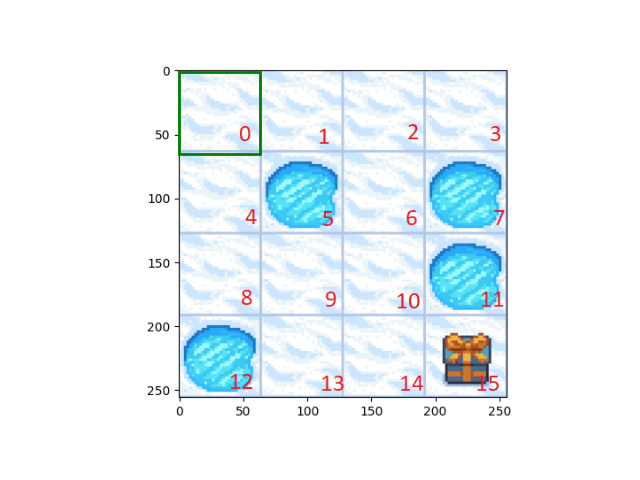

In [8]:

agent = Agent()

button_N = widgets.Button(description = "NORD")
button_O = widgets.Button(description = "OST")
button_S = widgets.Button(description = "SUED")
button_W = widgets.Button(description = "WEST")
button_Reset = widgets.Button(description = "RESET Umgebung")
buttons = [button_S, button_N, button_W, button_O]

output = widgets.Output()
img = Image.open('pics/Umgebung_numbered.png')

def get_Buttons(agent:Agent):
    valide_Richtungen = agent.umgebung.valide_Richtungen()
    valide_Buttons = [output]
    for button in buttons:
        if button.description in [richtung.name for richtung in valide_Richtungen]:
            valide_Buttons.append(button)
    return tuple(valide_Buttons)

def prev_Kachel_Richtung(agent:Agent):
    """ Gibt die vorletzte Position und Richtung zurück an der sich die Spielfigur befand. (Für Markierung in Q-Table)
    """
    position = agent.umgebung.position_Figur
    if not agent.umgebung.logbuch:
        return None, None
    prev_Richtung:Richtung = agent.umgebung.logbuch[-1]
    prev_Kachel = prev_Richtung.entgegengesetzte_Richtung().getKachel(position)
    return prev_Kachel, prev_Richtung

def get_table_map(agent:Agent):
    """Gibt eine HTML-bare Version von Q-Tabelle und Karte zurück.
    """
    return f"""
<div style="display: flex; align-items: flex-start;">
  <div style="margin-right: 20px;">{agent.qTabelle.anzeigen(*prev_Kachel_Richtung(agent))}</div>
  <div>{agent.umgebung.visualisiere_Fortschritt()}</div>
</div>
"""

display(*get_Buttons(agent), HTML(get_table_map(agent)))

def on_button_clicked(b):
    with output:
        richtung = Richtung._member_map_.get(b.description)

        if richtung:
            prev_QValue = agent.qTabelle.get_Wert(agent.umgebung.position_Figur, richtung)
            agent.step(richtung, learning_Rate, discount_Rate)
        if b is button_Reset:
            agent.umgebung.reset()
        
    clear_output(wait=False)
    display(*get_Buttons(agent), button_Reset, Latex(get_Equation(agent, prev_QValue)) if richtung else None, HTML(get_table_map(agent)))

def get_Equation(agent:Agent, previous_QValue:float):
    return "\\begin{{aligned}}q^{{new}}(s,a) &= (1-\\alpha) &\\cdot q( s,a) &+ \\alpha &( R_{{t+1}} &+ \\gamma &\\cdot q( s',a')&)\\\\ \
        q^{{new}}(s,a) &= {} &\\cdot {} &+ {} &({} &+ {} &\\cdot {} &) \\\\ &= {}\\end{{aligned}}"\
    .format(str(1-learning_Rate), previous_QValue, learning_Rate, agent.umgebung.get_Belohnung(), discount_Rate, agent.qTabelle.get_max_Value(agent.umgebung.position_Figur)[0],\
             agent.qTabelle.get_Wert(*prev_Kachel_Richtung(agent)))
    

button_N.on_click(on_button_clicked)
button_S.on_click(on_button_clicked)
button_W.on_click(on_button_clicked)
button_O.on_click(on_button_clicked)
button_Reset.on_click(on_button_clicked)

### 2. Training

agent trained


,NORD,OST,SUED,WEST
Kachel 0 |,N/A,10.667149999999998,10.667149999999998,N/A
Kachel 1 |,N/A,12.963499999999998,-11.036500000000002,8.600434999999997
Kachel 2 |,N/A,10.667149999999998,15.514999999999997,10.667149999999998
Kachel 3 |,N/A,N/A,-11.036500000000002,12.963499999999998
Kachel 4 |,8.600434999999997,-11.036500000000002,12.963499999999998,N/A
Kachel 5 |,10.667149999999998,15.514999999999997,15.514999999999997,10.667149999999998
Kachel 6 |,12.963499999999998,-11.036500000000002,18.349999999999998,-11.036500000000002
Kachel 7 |,10.667149999999998,N/A,-2.5,15.514999999999997
Kachel 8 |,10.667149999999998,15.514999999999997,-8.485000000000003,N/A
Kachel 9 |,-11.036500000000002,18.349999999999998,18.349999999999998,12.963499999999998


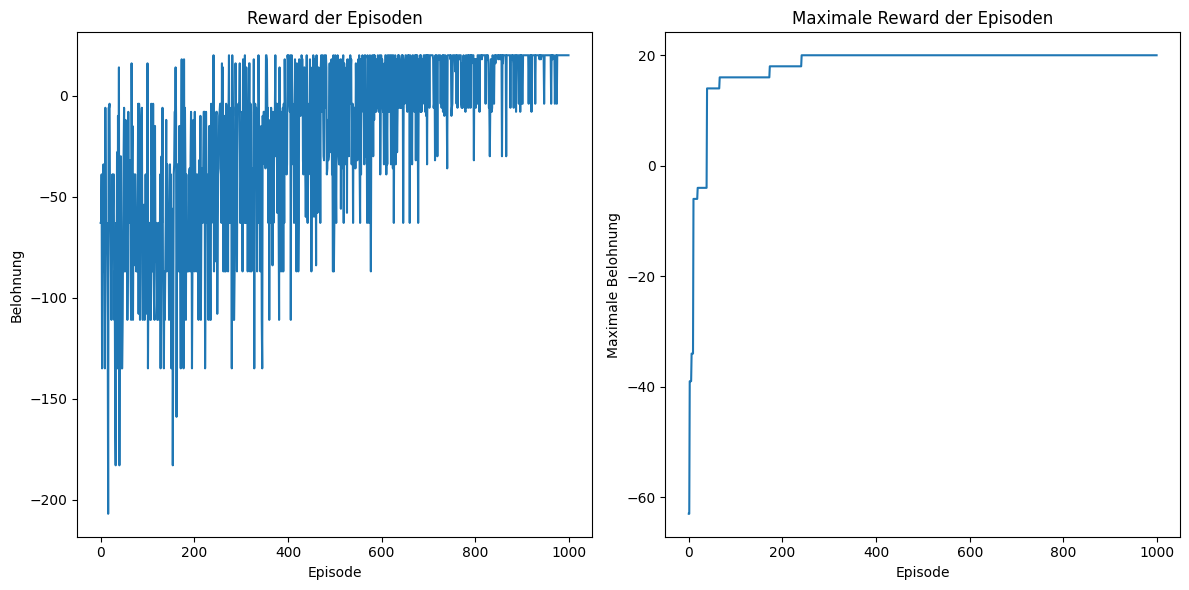

Bester Pfad
Maximale Belohnung  20 , mit Pfad: 



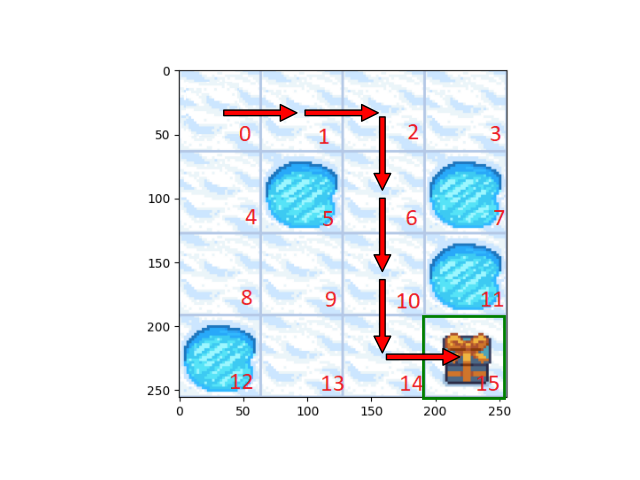

In [9]:
a = Agent()
belohnungen = a.train(1000, 15, learning_rate=0.8, discount_rate=0.9, remember_Episodes=5)
print("agent trained")

# Zeichne die Q-Tabelle nach dem Training
display(HTML(a.qTabelle.anzeigen()))

# Zeichne nur den maximalen Wert über die Episoden
max_value = belohnungen[0]
max_belohnungen = []
for belohnung in belohnungen:
    max_value = max(max_value, belohnung)
    max_belohnungen.append(max_value)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot data on the first subplot
ax1.plot(belohnungen)
ax1.set_title('Reward der Episoden')
ax1.set_xlabel('Episode')
ax1.set_ylabel('Belohnung')

# Plot data on the second subplot
ax2.plot(max_belohnungen)
ax2.set_title('Maximale Reward der Episoden')
ax2.set_xlabel('Episode')
ax2.set_ylabel('Maximale Belohnung')

plt.tight_layout()
plt.show()

# Zeige optimalen Pfad
pfad, belohnung = a.besterPfad()
print("Maximale Belohnung ", belohnung, ", mit Pfad: ")
display(HTML(a.umgebung.visualisiere_Fortschritt()))




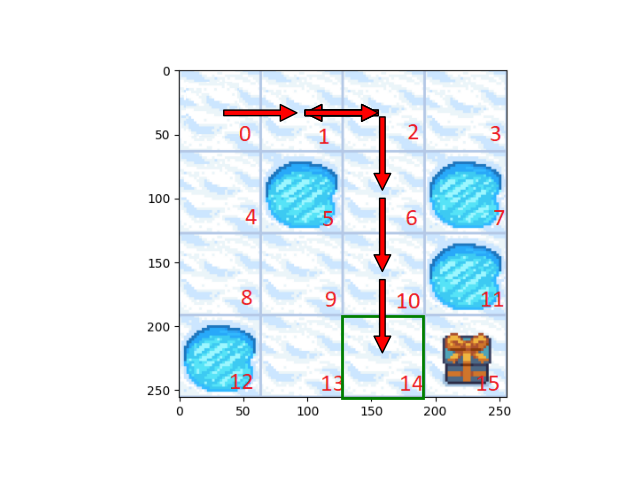

KeyboardInterrupt: 

In [11]:
# Animiere die ersten Episoden-Pfade des Agenten
saved_Episodes = a.safe_Episodes
for episode in saved_Episodes:
    for step in range(len(episode)):
        a.umgebung.reset()
        for richtung in episode[:step]:
            a.umgebung.step(richtung)
        display(HTML(a.umgebung.visualisiere_Fortschritt()))
        time.sleep(1.5)
        clear_output(wait=False)